In [11]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
import numpy as np
import torch
from tqdm import tqdm

SEED = 42

# Python 標準乱数
random.seed(SEED)
# NumPy
np.random.seed(SEED)
# PyTorch（CPU/GPU 両方）
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# 再現性のための設定
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- ハイパーパラメータ ---
latent_dim = 16
hidden_dim = 64
batch_size = 8
epochs = 100
lr = 1e-3

# 1. 埋め込み読み込み
embeddings = np.load("../../data/shared/embeddings.npy").astype(np.float32)
dataset = TensorDataset(torch.from_numpy(embeddings))
g = torch.Generator()
g.manual_seed(SEED)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=g)

In [3]:
# 2. VAE モデル定義
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu   = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return self.fc3(h)  # 出力は潜在特徴空間の再構成

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    



In [4]:
# 3. 損失関数
def vae_loss(recon_x, x, mu, logvar):
    # 再構成誤差 + KLダイバージェンス
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

In [6]:
# 4. モデル・オプティマイザ準備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = embeddings.shape[1]
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=lr)

Training: 100%|██████████| 100/100 [00:00<00:00, 196.14it/s]


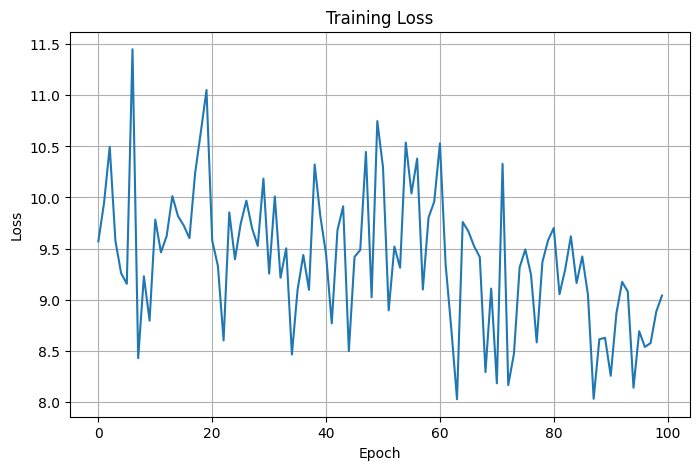

In [13]:
# 5. トレーニングループ

losses = []
vae.train()
for epoch in tqdm(range(epochs), desc="Training"):
    total_loss = 0
    for (batch,) in loader:
        x = batch.to(device)
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    losses.append(total_loss/len(dataset))

# ロスのグラフ表示
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [19]:
# 6. 新規サンプリング
vae.eval()
with torch.no_grad():
    # 正規分布から潜在 z をサンプリング
    torch.manual_seed(SEED)
    z_new = torch.randn(20, latent_dim).to(device)
    emb_new  = vae.decode(z_new).cpu().numpy()  # shape = (20, input_dim)

# ── ここで保存 ──────────────────────────────────────────
import numpy as np
np.save("emb_new.npy", emb_new)
print("emb_new.npy を保存しました")

emb_new.npy を保存しました


In [20]:
from sklearn.neural_network import MLPRegressor
X_scaled = np.load("../../data/shared/X_scaled.npy").astype(np.float32)
train_X = embeddings  # (n_services,64)
train_y = X_scaled    # (n_services,33)
reg = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=500, random_state=SEED)
reg.fit(train_X, train_y)


MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

In [21]:
# 7. DataFrame化して出力
import numpy as np
import pandas as pd

# 1. embeddings と feat_columns を読み込む
embeddings = np.load("../../data/shared/embeddings.npy")        # (n_services, latent_dim)
feat_cols = np.load("../../data/shared/feat_columns.npy", allow_pickle=True)  # array of feature names


X_new = reg.predict(emb_new)  # shape=(N,33)
# 元のスケーリングを戻すなら scaler.inverse_transform(X_new)
# 3. DataFrame化
new_df = pd.DataFrame(X_new, columns=feat_cols)



# 4. Excel出力
new_df.to_excel("new_potential_services.xlsx", index=False)
print("new_potential_services.xlsx に出力しました")


new_potential_services.xlsx に出力しました


In [22]:
display(new_df)

,UX_mean,UI_design,Player_usability,Catalogue_volume,Genre_coverage_within_category,New_release_speed,Genre_coverage_among_category,Cost_perf,Overall_satisfaction,NPS_intention,...,Genre_13_top_share,Genre_14_top_share,Genre_15_top_share,Original_viewer_share,Original_quality,Usage_tenure_months,Personal_pay_ratio,Extra_service_use,Corporate_trust,SDGs_influence
0,0.045475,-0.119152,-0.165718,-0.075334,-0.069147,-0.002186,0.042182,-0.359532,-0.145508,-0.188560,...,0.141126,0.246889,-0.126359,-0.170934,-0.485114,-0.025705,-0.146122,-0.091433,-0.488969,0.056639
1,-0.216212,-0.263636,-0.019112,-0.100869,-0.191990,0.023682,0.091963,-0.311336,-0.026722,0.273835,...,-0.069965,-0.059085,-0.066293,-0.064153,0.182292,-0.386268,-0.177722,0.196908,-0.075274,0.131183
2,-0.397183,-0.483745,-0.454667,-0.009849,-0.443055,-0.233733,-0.460516,-0.139995,-0.165885,-0.695528,...,0.126905,-0.211057,0.016757,-0.084749,-0.400872,0.308645,-0.033800,-0.693143,-0.358222,-0.845521
3,-0.036057,-0.138160,-0.098978,0.002434,-0.248823,0.243168,-0.570736,0.053996,0.229078,-0.079510,...,0.028330,-0.086730,-0.098448,-0.156612,0.438212,-0.523654,-0.121546,-0.550881,0.059084,-0.414161
4,-0.062436,-0.252725,-0.087280,-0.105660,0.003430,-0.118039,0.847952,-0.514507,-0.137910,0.235014,...,0.060831,0.033547,-0.190355,-0.047694,0.322636,-0.460248,0.022450,1.038216,-0.355692,0.653268
5,0.299420,0.490824,0.581817,0.539129,0.859535,0.704091,-0.393854,0.702253,0.710303,0.338900,...,-0.065493,-0.051946,0.021841,-0.234515,-0.123321,1.229800,-0.275691,0.131308,0.523951,-0.254495
6,-0.478616,-0.321681,-0.412046,-0.207772,-0.494397,-0.295882,-0.207095,-0.241393,-0.278021,-0.630684,...,0.052340,-0.241795,0.101301,-0.052559,-0.403515,0.276396,-0.133143,-0.615054,-0.327790,-0.625157
7,-0.275915,-0.082193,-0.200797,-0.188438,-0.086717,0.013477,-0.192171,-0.093126,0.157485,-0.235357,...,-0.068811,-0.119265,0.005957,-0.135177,0.194694,-0.297975,-0.238129,-0.548357,-0.000684,-0.225896
8,0.080847,0.082357,0.044702,-0.180265,0.160422,0.345705,0.557992,-0.103237,0.383610,0.516550,...,0.005328,0.326025,-0.154352,-0.263632,0.250032,-0.232377,-0.232148,-0.115920,0.247930,0.345384
9,-0.545085,-0.491753,-0.414948,-0.341240,-0.675262,-0.178941,-0.508586,-0.232884,-0.117512,-0.608440,...,0.111567,-0.327167,-0.021692,-0.209991,-0.459113,0.318414,-0.136460,-0.931922,-0.442555,-0.920458


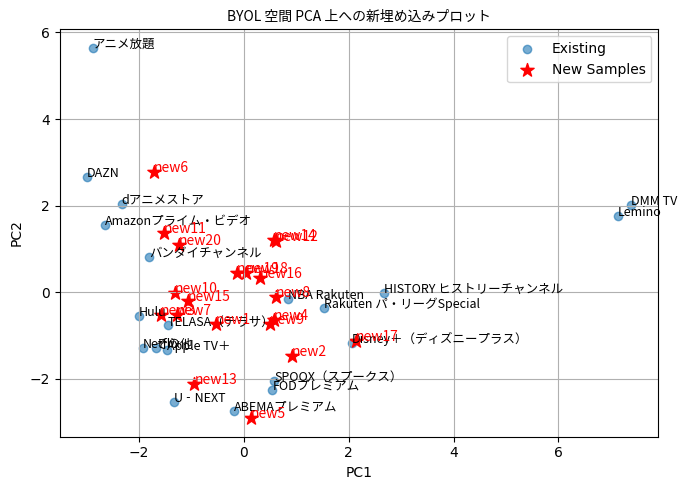

/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


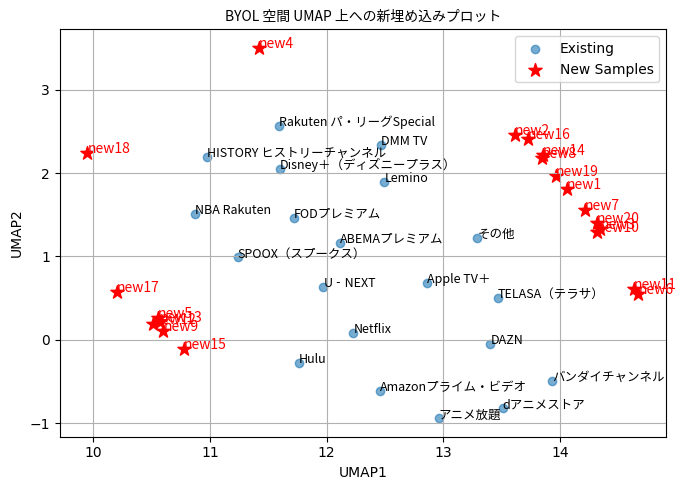

In [23]:
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import numpy as np

# ── フォント設定 ─────────────────────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")

# 0. 既存埋め込み & 新埋め込み 読み込み
embeddings = pd.DataFrame(
    np.load("../../data/shared/embeddings.npy"),
    index=feat_df.index
)
# emb_new は VAE.decode() の結果（shape=(N_new, D) の numpy array）
# 例: emb_new = emb_new  # 既に定義済み

# ── PCA のプロット ────────────────────────────────────────────
pca = PCA(n_components=2, random_state=SEED, svd_solver="full")
coords_orig = pca.fit_transform(embeddings)
coords_new  = pca.transform(emb_new)    # 新埋め込みも同じ PCA 空間に射影

plt.figure(figsize=(7,5))
# 元サービス
plt.scatter(coords_orig[:,0], coords_orig[:,1], alpha=0.6, label="Existing")
for svc, (x,y) in zip(embeddings.index, coords_orig):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=9)

# 新規候補
plt.scatter(coords_new[:,0], coords_new[:,1], marker="*", c="red", s=100, label="New Samples")
for i, (x,y) in enumerate(coords_new):
    plt.text(x, y, f"new{i+1}", fontproperties=font_prop, color="red")

plt.title("BYOL 空間 PCA 上への新埋め込みプロット", fontproperties=font_prop)
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# ── UMAP のプロット ──────────────────────────────────────────
um = umap.UMAP(n_components=2, random_state=SEED)
coords_umap_orig = um.fit_transform(embeddings)
coords_umap_new  = um.transform(emb_new)  # transform が使える umap-learn であれば

plt.figure(figsize=(7,5))
plt.scatter(coords_umap_orig[:,0], coords_umap_orig[:,1], alpha=0.6, label="Existing")
for svc, (x,y) in zip(embeddings.index, coords_umap_orig):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=9)

plt.scatter(coords_umap_new[:,0], coords_umap_new[:,1], marker="*", c="red", s=100, label="New Samples")
for i, (x,y) in enumerate(coords_umap_new):
    plt.text(x, y, f"new{i+1}", fontproperties=font_prop, color="red")

plt.title("BYOL 空間 UMAP 上への新埋め込みプロット", fontproperties=font_prop)
plt.legend()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.tight_layout()
plt.show()


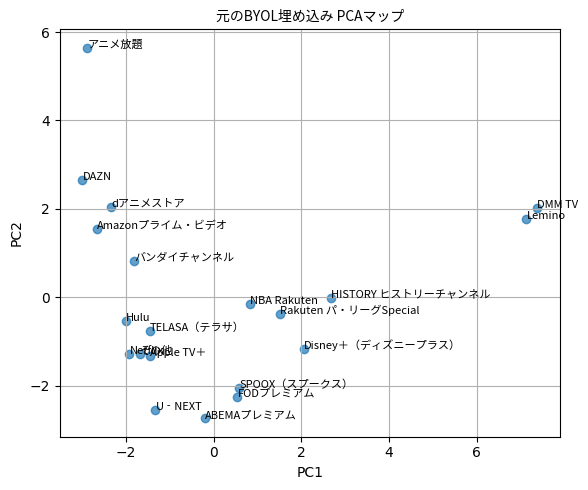

/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


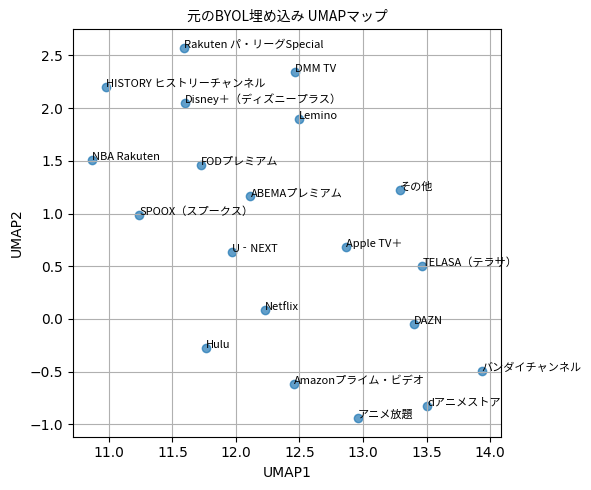

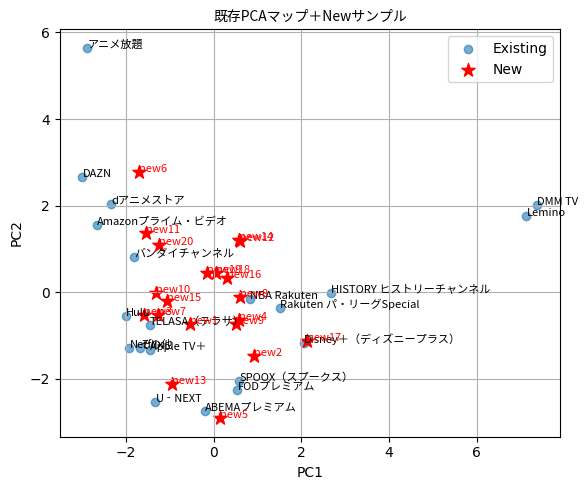

/home/fuukanoo/workspace/jisyu-zemi/ORICON/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


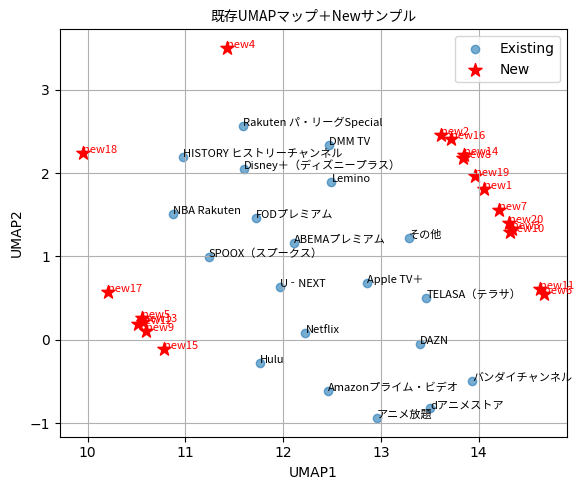

In [24]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# フォント設定
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# feat_df, embeddings, emb_new をそれぞれ読み込んでおく
feat_df      = pd.read_pickle("../../data/shared/feat_df.pkl")
emb_existing = np.load("../../data/shared/embeddings.npy")
emb_new      = np.load("emb_new.npy")

# ────────────────────────────────────────────
# ① 元の PCA/UMAP マップ（既存サービスのみ）
# ────────────────────────────────────────────
# PCA
pca_orig = PCA(n_components=2, random_state=SEED, svd_solver="full").fit(emb_existing)
coords_pca_orig = pca_orig.transform(emb_existing)

plt.figure(figsize=(6,5))
plt.scatter(coords_pca_orig[:,0], coords_pca_orig[:,1], alpha=0.7)
for svc, (x,y) in zip(feat_df.index, coords_pca_orig):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=8)
plt.title("元のBYOL埋め込み PCAマップ", fontproperties=font_prop)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True); plt.tight_layout()
plt.show()

# UMAP
um_orig = umap.UMAP(n_components=2, random_state=SEED).fit(emb_existing)
coords_umap_orig = um_orig.transform(emb_existing)

plt.figure(figsize=(6,5))
plt.scatter(coords_umap_orig[:,0], coords_umap_orig[:,1], alpha=0.7)
for svc, (x,y) in zip(feat_df.index, coords_umap_orig):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=8)
plt.title("元のBYOL埋め込み UMAPマップ", fontproperties=font_prop)
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.grid(True); plt.tight_layout()
plt.show()


# ────────────────────────────────────────────
# ② 既存マップに “new” を追加プロット
# ────────────────────────────────────────────
# PCA 空間に new を追加
coords_new_pca = pca_orig.transform(emb_new)

plt.figure(figsize=(6,5))
plt.scatter(coords_pca_orig[:,0], coords_pca_orig[:,1], alpha=0.6, label="Existing")
for svc, (x,y) in zip(feat_df.index, coords_pca_orig):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=8)

plt.scatter(coords_new_pca[:,0], coords_new_pca[:,1],
            marker="*", c="red", s=100, label="New")
for i, (x,y) in enumerate(coords_new_pca,1):
    plt.text(x, y, f"new{i}", fontproperties=font_prop,
             color="red", fontsize=8)

plt.title("既存PCAマップ＋Newサンプル", fontproperties=font_prop)
plt.legend(); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True); plt.tight_layout()
plt.show()

# UMAP 空間も同様
coords_new_umap = um_orig.transform(emb_new)

plt.figure(figsize=(6,5))
plt.scatter(coords_umap_orig[:,0], coords_umap_orig[:,1], alpha=0.6, label="Existing")
for svc, (x,y) in zip(feat_df.index, coords_umap_orig):
    plt.text(x, y, svc, fontproperties=font_prop, fontsize=8)

plt.scatter(coords_new_umap[:,0], coords_new_umap[:,1],
            marker="*", c="red", s=100, label="New")
for i, (x,y) in enumerate(coords_new_umap,1):
    plt.text(x, y, f"new{i}", fontproperties=font_prop,
             color="red", fontsize=8)

plt.title("既存UMAPマップ＋Newサンプル", fontproperties=font_prop)
plt.legend(); plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.grid(True); plt.tight_layout()
plt.show()
